# DSM010 Big Data  - Coursework 2: "Flight Delays"

# Introduction

For centuries, people have looked at the birds in the sky and wished to fly like a bird. The first flight by humanity was in 1783 in a hot air balloon. Attempts at flight, however, go back much further in time. This is also reflected in mystical stories, such as the Greek legend of Icarus and Daedalus, or King Kaj Kaoos of Persia who attached eagles to his throne and flew around his kingdom [1]. Nowadays, people still dream of flying. However, the dream is more about the longing for the next holiday trip and the experiences and feelings associated with it. Flying has become a part of our everyday lives and is omnipresent in the sky simply because of the various flying machines. Flying is no longer a vague subject. It is one of the safest means of travelling long distances. According to IATA (International Air Transportation Association), it is the safest way to travel long distances. The fatal accident rate is 0.28% per 1 million flights. This means that there is one fatal accident per 4.2 million flights [2]. To put this into relation with current figures: in 2020 (Pre-Covid) there were 40.3 million flights. During the pandemic annual flights declined by roughly 60% and are still recovering [3]. Looking at all this numbers it is obvious that taking a flight is safe and a crucial part of live. Independently from holiday or business trips. Still, going by plane is a exciting thing and based on personal experience it is very stressful if all the planning around a flight is disturbed by a delayed flight. This proposal deals with flight delays and aims to answer the question of whether there is a pattern behind delays and whether delays can be predicted on the basis of various criteria.

Before this coursework is dedicated to the hypotheses, the data should first be loaded into the PySpark session to get a first impression. 

# Loading the Data

The datasets used here can be downloaded from the following link: https://www.kaggle.com/datasets/arvindnagaonkar/flight-delay

Before the data can be loaded and analysed, the data set has been downloaded to the local machine. I will discuss the data sources and the data itself later in the paper.

After the data was stored locally, it was transferred to the remote machine using an ssh command. The following command was executed:

In [ ]:
# scp -r ./data psuff001@lena.doc.gold.ac.uk:./cw2

With this command, all files in the folder "data" were loaded from the local machine to the corresponding remote machine.

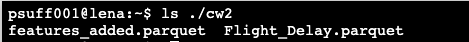

The data from the remote machine was then loaded into the hadoop cluster. The following command was used for this:

In [95]:
# hadoop fs -copyFromLocal ./cw2/Flight_Delay.parquet ./cw2/data/fligh_delay.parquet

After executing the above command, the datasets were available in the folder cw2/data.

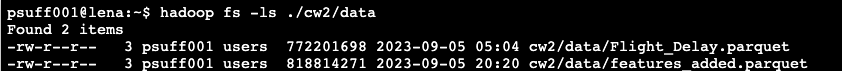


This meant that the data was available for further processing and analysis using Spark.

# Setting Up the Environment

In [96]:
# Import Sparksession
from pyspark.sql import SparkSession

In [97]:
# Create new spark session
spark_session = SparkSession.builder.appName('cw2').master('yarn').getOrCreate()

In [98]:
# print the current spark session
print(spark_session)

In [99]:
# print tables in the catalog
print(spark_session.catalog.listTables())

[]


## Loading the files

At this point it must be taken into account that the dataset comes with two files. One dataset is close to the original state. The other dataset contains additional properties. I will load both datasets at the beginning and include them. In the end, however, only the dataset close to the original data will be used for the further steps.

In [101]:
# Define variable for file path
file_path = 'hdfs:///user/psuff001/cw2/data/Flight_Delay.parquet'
file_path_features_added= 'hdfs:///user/psuff001/cw2/data/features_added.parquet'

In [102]:
# Import library to measure time
import time

# capture start time
start_time= time.time()

# Load parquet file from HDFS using the defined file path
df_flights = spark_session.read.parquet(file_path)
df_features_added = spark_session.read.parquet(file_path_features_added)

# capture endtime 
end_time= time.time()

# print the time needed to execution => This was done to give my fellow students a reference for the loading time of data
print(f'Time needed to load dataset {end_time - start_time} in seconds')

Time needed to load dataset 1.1987321376800537 in seconds


In [103]:
# Show first five records of dataframe
df_flights.show(5)

+----+-----+----------+----------+-------------------------+--------------+--------------+----------+-------+--------+---------------+-------+---------+--------+------+----------+-------+--------+---------------+--------------+-----------------+-------+--------+-------------+------------+------------+--------+-------------+-----------------+-----------------+
|Year|Month|DayofMonth|FlightDate|Marketing_Airline_Network|OriginCityName|  DestCityName|CRSDepTime|DepTime|DepDelay|DepDelayMinutes|TaxiOut|WheelsOff|WheelsOn|TaxiIn|CRSArrTime|ArrTime|ArrDelay|ArrDelayMinutes|CRSElapsedTime|ActualElapsedTime|AirTime|Distance|DistanceGroup|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|__index_level_0__|
+----+-----+----------+----------+-------------------------+--------------+--------------+----------+-------+--------+---------------+-------+---------+--------+------+----------+-------+--------+---------------+--------------+-----------------+-------+--------+-------------+

In [8]:
# Show first five records of dataframe
df_features_added.show(5)

+----+-----+----------+-------------------+-------------------------+--------------+--------------+-------+--------+---------------+-------+------+-------+--------+---------------+--------------+-----------------+-------+--------+-------------+------------+------------+--------+-------------+-----------------+---------+--------+----------------+--------------+---------------+-------------+----------------+--------------+--------------+------------+-----------------+----------------+-----------------+---------------+-------------------+-----------------+
|Year|Month|DayofMonth|         FlightDate|Marketing_Airline_Network|OriginCityName|  DestCityName|DepTime|DepDelay|DepDelayMinutes|TaxiOut|TaxiIn|ArrTime|ArrDelay|ArrDelayMinutes|CRSElapsedTime|ActualElapsedTime|AirTime|Distance|DistanceGroup|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|DayofWeek|Holidays|CRSDepTimeMinute|CRSDepTimeHour|WheelsOffMinute|WheelsOffHour|CRSArrTimeMinute|CRSArrTimeHour|WheelsOnMinute|W

Only by looking at the table headers can it be seen that the dataset with the name 'added_features' holds significantly more properties. A comparison of the respective features is made in the further course of the work.

# Data Description & Preliminary Exploration

The dataset called “Flight Delay” was downloaded from the online community platform Kaggle [4]. In General the dataset consists of two files (“Flight_Delay.parquet” and “features_added.parquet”) in the Parquet-Format. It is format established by Apache in column-oriented opensource format. Parquet was designed for efficient data storage and retrieval in the Hadoop ecosystem[5]. The original data was sourced from the Bureau of Transportation Statistics (BTS). The BTS is one of many federal statistical agencies and is a significant source for statistics on commercial aviation [6]. The dataset is licensed with CCO 1.0 Universal (CCO 1.0) Public Domain Dedication. That means the data were released into public domain. Therefore the data can be copied, modified, distributed, and performed even for commercial purposes [7]. The data is frequently updated and expected to be updated annually. The last update of the dataset was performed at 04/2023. The data focuses on flights in the United States. It covers a period from 2018 to April 2023. Only delayed flights were considered. Cancellations or diverted flights are not represented in the dataset [8].

First I will look at the dataframe 'df_flights', then the dataframe 'df_features_added'.

In [104]:
# Getting an overview of given columns and corresponding datatypes
for col in df_flights.dtypes:
    print(f'{col[0]} --> {col[1]}')

Year --> bigint
Month --> bigint
DayofMonth --> bigint
FlightDate --> string
Marketing_Airline_Network --> string
OriginCityName --> string
DestCityName --> string
CRSDepTime --> bigint
DepTime --> double
DepDelay --> double
DepDelayMinutes --> double
TaxiOut --> double
WheelsOff --> double
WheelsOn --> double
TaxiIn --> double
CRSArrTime --> bigint
ArrTime --> double
ArrDelay --> double
ArrDelayMinutes --> double
CRSElapsedTime --> double
ActualElapsedTime --> double
AirTime --> double
Distance --> double
DistanceGroup --> bigint
CarrierDelay --> double
WeatherDelay --> double
NASDelay --> double
SecurityDelay --> double
LateAircraftDelay --> double
__index_level_0__ --> bigint


In [105]:
# Getting an overview of given columns and corresponding datatypes
for col in df_features_added.dtypes:
    print(f'{col[0]} --> {col[1]}')

Year --> bigint
Month --> bigint
DayofMonth --> bigint
FlightDate --> timestamp
Marketing_Airline_Network --> string
OriginCityName --> string
DestCityName --> string
DepTime --> double
DepDelay --> double
DepDelayMinutes --> double
TaxiOut --> double
TaxiIn --> double
ArrTime --> double
ArrDelay --> double
ArrDelayMinutes --> double
CRSElapsedTime --> double
ActualElapsedTime --> double
AirTime --> double
Distance --> double
DistanceGroup --> bigint
CarrierDelay --> double
WeatherDelay --> double
NASDelay --> double
SecurityDelay --> double
LateAircraftDelay --> double
DayofWeek --> bigint
Holidays --> boolean
CRSDepTimeMinute --> int
CRSDepTimeHour --> int
WheelsOffMinute --> int
WheelsOffHour --> int
CRSArrTimeMinute --> int
CRSArrTimeHour --> int
WheelsOnMinute --> int
WheelsOnHour --> int
CRSDepTimeHourDis --> string
WheelsOffHourDis --> string
CRSArrTimeHourDis --> string
WheelsOnHourDis --> string
CRSElapsedTimeGorup --> bigint
__index_level_0__ --> bigint


In [107]:
# Have a detailed look at the different features
df_flights_cols= df_flights.columns
df_added_cols= df_features_added.columns

# Showing columns different in either dataframes
diff_both= list(set(df_flights_cols) ^ set(df_added_cols))

for element in diff_both:
    print(element)
    
print(f'The dataframe features_added has {len(diff_both)} additional elements.')

WheelsOn
DayofWeek
WheelsOffHour
CRSArrTimeHourDis
WheelsOnHourDis
CRSArrTime
Holidays
CRSDepTimeMinute
CRSDepTimeHour
CRSArrTimeHour
WheelsOnHour
CRSArrTimeMinute
WheelsOffMinute
WheelsOffHourDis
CRSElapsedTimeGorup
CRSDepTimeHourDis
WheelsOff
CRSDepTime
WheelsOnMinute
The dataframe features_added has 19 additional elements.


Following I will take a closer look on the data itself.

In [108]:
# Let's have a detailed look at the first a record of the df_flights dataframe
first_entry= df_flights.first().asDict()

for key, value in first_entry.items():
    print(f'{key}: {value}')

Year: 2018
Month: 1
DayofMonth: 15
FlightDate: 2018-01-15
Marketing_Airline_Network: UA
OriginCityName: Newark, NJ
DestCityName: Charleston, SC
CRSDepTime: 1845
DepTime: 1928.0
DepDelay: 43.0
DepDelayMinutes: 43.0
TaxiOut: 35.0
WheelsOff: 2003.0
WheelsOn: 2145.0
TaxiIn: 4.0
CRSArrTime: 2108
ArrTime: 2149.0
ArrDelay: 41.0
ArrDelayMinutes: 41.0
CRSElapsedTime: 143.0
ActualElapsedTime: 141.0
AirTime: 102.0
Distance: 628.0
DistanceGroup: 3
CarrierDelay: 41.0
WeatherDelay: 0.0
NASDelay: 0.0
SecurityDelay: 0.0
LateAircraftDelay: 0.0
__index_level_0__: 1


In [109]:
# Let's have a detailed look at the first a record of the df_features_added dataframe
first_entry= df_features_added.first().asDict()

for key, value in first_entry.items():
    print(f'{key}: {value}')

Year: 2018
Month: 1
DayofMonth: 15
FlightDate: 2018-01-15 00:00:00
Marketing_Airline_Network: UA
OriginCityName: Newark, NJ
DestCityName: Charleston, SC
DepTime: 1928.0
DepDelay: 43.0
DepDelayMinutes: 43.0
TaxiOut: 35.0
TaxiIn: 4.0
ArrTime: 2149.0
ArrDelay: 41.0
ArrDelayMinutes: 41.0
CRSElapsedTime: 143.0
ActualElapsedTime: 141.0
AirTime: 102.0
Distance: 628.0
DistanceGroup: 3
CarrierDelay: 41.0
WeatherDelay: 0.0
NASDelay: 0.0
SecurityDelay: 0.0
LateAircraftDelay: 0.0
DayofWeek: 0
Holidays: True
CRSDepTimeMinute: 45
CRSDepTimeHour: 18
WheelsOffMinute: 3
WheelsOffHour: 20
CRSArrTimeMinute: 8
CRSArrTimeHour: 21
WheelsOnMinute: 45
WheelsOnHour: 21
CRSDepTimeHourDis: Evening
WheelsOffHourDis: Evening
CRSArrTimeHourDis: Night
WheelsOnHourDis: Night
CRSElapsedTimeGorup: 3
__index_level_0__: 1


In [111]:
# Show the number of records/observation stored in the dataset
print(f'Number of observations in flight delay dataset: {df_flights.count()}')

Number of observations in flight delay dataset: 30132672


In [112]:
# Show the number of records/observation stored in the dataset
print(f'Number of observations in features added dataset: {df_features_added.count()}')

Number of observations in features added dataset: 30132631


In [113]:
# Print the numbers of partitions on which the data is stored
print(f'The dataframe df_flights is distributed on {df_flights.rdd.getNumPartitions()} partitions')

The dataframe df_flights is distributed on 6 partitions


In [114]:
# Print the numbers of partitions on which the data is stored
print(f'The dataframe df_features_added is distributed on {df_features_added.rdd.getNumPartitions()}partitions')

The dataframe df_features_added is distributed on 7partitions


It is clear from comparing the two datasets supplied that the additional information in 'features_added' comes from conversions and classifications of time units in the initial dataset. For example, the arrival time 'CSRArrTime' is represented as a double value in the form of '2349.00'. This value is therefore represented in 'features_added' as a 'CSRArrTimeHour' and 'CSRArrTimeMinute'. This is similar for a few other features, such as 'CRSDepTime'.

Im summary the two files of the dataset have a size of 1.59 Gigabyte (flights_delay.parquet is 772.2 MB / features_added.parquet is 818.8 MB) in total. Both files of the dataset hold different features. The first file holds 29 columns and have in total 30’132’672 observations. The second file contains 40 features and holds 30’132’631. Both files rdds are dirtibruted in 6 to 7 partitions.

Regardless of which file is ultimately used, it can be said that both files are suitable for analysis in the context of big data.

For the following steps including the analysis I will use the datafram df_flights, based on the file 'flights_delay.parquet'.

In [115]:
# Having a look at a second randomly choosen entry
random_flight= df_flights.sample(False, 0.001).first().asDict()

for key, value in random_flight.items():
    print(f'{key}: {value}')

Year: 2018
Month: 1
DayofMonth: 1
FlightDate: 2018-01-01
Marketing_Airline_Network: F9
OriginCityName: Philadelphia, PA
DestCityName: Charlotte, NC
CRSDepTime: 1244
DepTime: 1345.0
DepDelay: 61.0
DepDelayMinutes: 61.0
TaxiOut: 12.0
WheelsOff: 1357.0
WheelsOn: 1519.0
TaxiIn: 8.0
CRSArrTime: 1445
ArrTime: 1527.0
ArrDelay: 42.0
ArrDelayMinutes: 42.0
CRSElapsedTime: 121.0
ActualElapsedTime: 102.0
AirTime: 82.0
Distance: 449.0
DistanceGroup: 2
CarrierDelay: 42.0
WeatherDelay: 0.0
NASDelay: 0.0
SecurityDelay: 0.0
LateAircraftDelay: 0.0
__index_level_0__: 5859


It is interessting to see, that the date choosen is close to the first record of data frame. Lets have quick look at the covered time periods. To do this in a simple way I register as a temporary sql view. So that I can perform easier commands.

I also notice that this observation has a negative value for the 'DepDelay' property. This is also evident in the 'ArrDelay'. In addition, the 'CarrierDelay', 'WeatherDelay', 'NASDelay' and 'SecurityDelay' are all set to 0. This would mean that the flight could take off 7 minutes earlier and also reach its destination 7 minutes earlier without any kind of delay.

In [116]:
# Register as temp table to use sql functionality
df_flights.createOrReplaceTempView('flights')

In [117]:
# check if dataframe was registered as temp table view
print(spark_session.catalog.listTables())

[Table(name='flights', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]


In [118]:
# Check the distinct values for the column 'year'
distinct_years= df_flights.select('year').distinct()
distinct_years.show()

+----+
|year|
+----+
|2021|
|2022|
|2018|
|2020|
|2023|
|2019|
+----+



It gives the impression that an entry was selected at random that is in the same year. The table above clearly shows that the given data covers the years from 2018 to 2023.

In [120]:
# Query the mean delay of all flights and years
avg_delays = spark_session.sql('SELECT avg(DepDelay), avg(ArrDelay) from flights').collect()
print(
    f"The average departure delay is: {avg_delays[0]['avg(DepDelay)']} minutes \n"
    f"The average arrival delay is: {avg_delays[0]['avg(ArrDelay)']} minutes"
)

The average departure delay is: 10.611442025453302 minutes 
The average arrival delay is: 3.754416800474913 minutes


In [121]:
# Querying the mean delays grouped by years
delays_by_years= spark_session.sql('SELECT year, avg(DepDelay) as AvgDepDelay, avg(ArrDelay) as AvgArrDelay, count(*) as AmtFlights from flights GROUP BY year').collect()
delays_by_years

[Row(year=2021, AvgDepDelay=10.233864225814488, AvgArrDelay=2.7361038090682204, AmtFlights=5234456),
 Row(year=2022, AvgDepDelay=13.717417900808877, AvgArrDelay=7.061611393510928, AmtFlights=5706055),
 Row(year=2018, AvgDepDelay=11.163514924775058, AvgArrDelay=5.067184163654086, AmtFlights=6438556),
 Row(year=2020, AvgDepDelay=2.0338133657078155, AvgArrDelay=-6.352663361235913, AmtFlights=4148123),
 Row(year=2023, AvgDepDelay=13.972326434262108, AvgArrDelay=7.916352801079121, AmtFlights=1897840),
 Row(year=2019, AvgDepDelay=12.087613650221643, AvgArrDelay=5.548441762395787, AmtFlights=6707642)]

In [122]:
# In order to show the tabular data in a more readable manner pandas will be used
import pandas as pd

df_delays_by_years= pd.DataFrame([row.asDict() for row in delays_by_years])
df_delays_by_years

,year,AvgDepDelay,AvgArrDelay,AmtFlights
0,2021,10.233864,2.736104,5234456
1,2022,13.717418,7.061611,5706055
2,2018,11.163515,5.067184,6438556
3,2020,2.033813,-6.352663,4148123
4,2023,13.972326,7.916353,1897840
5,2019,12.087614,5.548442,6707642


This small overview gives a good first overview of the data. It looks like on average there are the most delays at departure and arrival in 2023. It must be taken into account that the year 2023 is not yet complete. Most flights took place in 2018, 2019. In 2020, there is a significant decrease in flights due to the C19 pandemic. In the years following the pandemic, flights have increased again, but the pre-pandemic number of flights has not been reached.

# Hypothesis

Initially in this section, I would like to focus on a specific operational concern of flight management: The understanding between departure and arrival delays. In the data, there were examples where departure delays could be made up, or flights took off without delay but still arrived late at their destination. In this context, the aim is to test that the departure delay does not have a significant impact on the probability of an arrival delay.   Thus, the null hypothesis states: The probability that a flight has a departure delay has no significant influence on the probability that the same flight has an arrival delay. The alternative hypothesis is therefore: A departure delay increases the probability of a subsequent arrival delay.

After gaining an impression of how a departure delay and an arrival delay are related, it would be interesting to have a closer look at the amount of delays and how they might change over a period. With this dataset, it could be particularly interesting, as the Corona year 2020 is mapped and thus the period in which a lot of following took place is covered, up to no flights and a renewed increase after the Corona years 2021-2023. Therefore, the hypothesis would be: The number of delayed flights is linear to the total amount of flights. The alternative hypothesis is: The number of observed delays is not linearly to the total number of flights. The following sub-hypothesis follow: Some airlines have significantly more delays then others. Some months of the year face a much higher amount of delays then others of the year (eg. Due to holidays)

Finally, I would like to examine the causes of flight delays, focusing particularly on weather conditions. It is a widely held belief that weather is a major cause of delays. When examining the dataset, the WeatherDelay feature stands out as the only representative variable for weather-related delays. However, it is crucial to note that this is not an independent variable describing weather conditions such as rain or snow, but rather captures the duration of delay that is due to weather. An important aspect of this is that the dataset captures only delayed flights, indicating that despite potential weather problems, conditions were not severe enough to prevent departure. Therefore, my central hypothesis is that arrival delays are not due to bad weather and have the smallest impact on total delay duration. The Alternatov hypothesis, on the other hand, assumes a significant delay contribution from adverse weather conditions. This results in a second hypothesis: greater delays in arrivals are due to an interaction of external variables. The counter hypothesis states that significant delays are due to individual external challenges, such as logistical complications.


## Hypothesis I - Flight Delays

In this section I want to validate the Hypothesis: The probability of a flight having a departure delay does not significantly affect the probability of the flight having an arrival delay. The alternative hypothesis is: The probability of a flight having a departure delay significantly increases the probability of the flight having an arrival delay.

To test this hypothesis statistically, I will first create a correlation matrix between departure delays and arrival delays. Then, I will build a regression model to predict the probabilities of a late arrival based on a late take-off. If the coefficient is significantly positive, this supports the hypothesis. 

Finally, the flights are divided into four categories using the Chi-Squared test: 
- No delay at take-off & No delay at arrival.
- Delay at take-off & No delay at arrival
- No delay at take-off & delay at arrival
- Delayed take-off & delayed arrival

The test can be used to determine whether there is a significant relationship between departure and arrival delays.

### Correlation - Depaturer Delays and Arrival Delays

In [123]:
corr_dep_arr_delay= df_flights.corr('DepDelay','ArrDelay')
print(f'The correlation coeffiecent between the depature delay and arrival delay is: {corr_dep_arr_delay}')

The correlation coeffiecent between the depature delay and arrival delay is: 0.9688436414428219


The correlation coefficient is positive at 0.968 and almost reaches the value 1. This means that the variables DepDelay and ArrDelay are closely related. And thus a late departure time has a strong influence on a late arrival time.

### Building Regression Model

In [124]:
# import necessary libs
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline

In [125]:
# select data
delays= df_flights.select('DepDelay','ArrDelay')

In [126]:
# Create Vector Assembler
assembler= VectorAssembler(inputCols=['DepDelay'], outputCol='features')

In [127]:
# Defining the regression model
lr= LinearRegression(featuresCol='features', labelCol='ArrDelay', predictionCol='predicted_arr_delay')

In [128]:
# defining ml pipline with corresponding satges
pipeline= Pipeline(stages=[assembler, lr])

In [129]:
# execute the pipline with the filtered data
model= pipeline.fit(delays)

In [130]:
# Import the RegressionEvaluator module from PySpark's MLlib
from pyspark.ml.evaluation import RegressionEvaluator

# Use the trained model to make predictions on the 'delays' dataset
predictions = model.transform(delays)

# Initialize the regression evaluator with the actual and predicted columns, and specify the evaluation metric as RMSE
evaluator = RegressionEvaluator(labelCol='ArrDelay', predictionCol='predicted_arr_delay', metricName='rmse')

# Calculate the RMSE (Root Mean Squared Error) for the predictions
rmse = evaluator.evaluate(predictions)

# Print out the calculated RMSE
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 13.509648557627134


In [68]:
# Get linear regression model from the last stage of the pipeline model
linear_model = model.stages[-1]

# Print out the coefficient associated with the predictor
print(f"Coefficient for departure_delay: {linear_model.coefficients}")

# Print out the y-intercept
print(f"Intercept: {linear_model.intercept}")


Coefficient for departure_delay: [4.208752612446717,4.68085004210712,2.1523916631090674,-0.8143091326252104]
Intercept: 0.8417200107577569


The model coefficient is slightly above 1 and the intercept is just under -7. This means that there is almost a one-to-one relationship between the DepDealay and ArrDelay. Thus, it is very likely that for every minute of delay in departure, a minute of delay in arrival is added.  The intercept indicates that the flight will reach its destination 7 minutes earlier if the aircraft can depart on time. This can be influenced by various factors, such as weather conditions and the like. However, we will not go into this further at this point.

In summary, the model suggests that departure and arrival delays are directly related. 

### Building a Contingency Matrix

In [254]:
# Import the necessary libraries
from pyspark.sql import functions as F

In [257]:
# Categorize delays in preperation of contingency table

# Select the needed columns
df_flights_delays= df_flights.select('ArrDelay', 'DepDelay')

# Update the `df_flights_delays` DataFrame by adding a new column 'DepDelayCategory'. 
# If 'DepDelay' column's value is greater than 0, label it as "Delay Departure"; otherwise, label it as "No Delay Departure".
df_flights_delays= df_flights_delays.withColumn('DepDelayCategory',F.when(F.col('DepDelay')>0, "Delay Departure").otherwise('No Delay Departure'))

# Cache the `df_flights_delays` DataFrame in memory for faster subsequent operations.
df_flights_delays.cache()


DataFrame[ArrDelay: double, DepDelay: double, DepDelayCategory: string]

In [258]:
df_flights_delays= df_flights_delays.withColumn('ArrDelayCategory',F.when(F.col('ArrDelay')>0, "Delay Arrival").otherwise('No Delay Arrival'))
df_flights_delays.cache()

DataFrame[ArrDelay: double, DepDelay: double, DepDelayCategory: string, ArrDelayCategory: string]

In [261]:
# Create contingency table
contingency_table= df_flights_delays.groupBy("DepDelayCategory", "ArrDelayCategory").count() # don't chain show() action it will turn df in Type 'NoneType'

In [273]:
# show contingency table
contingency_table.show()

+------------------+----------------+--------+
|  DepDelayCategory|ArrDelayCategory|   count|
+------------------+----------------+--------+
|   Delay Departure|   Delay Arrival| 5680003|
|   Delay Departure|No Delay Arrival| 3252397|
|No Delay Departure|No Delay Arrival|20408527|
|No Delay Departure|   Delay Arrival|  791745|
+------------------+----------------+--------+



The contingency matrix shows the different combinations of delays:
- Delay Departure <> Delay Arrival
- Delay Departure <> No Delay Arrival
- No Delay Departure <> No Delay Arrival
- No Delay Departure <> Delay Arrival

There are now two situations to consider: Flights that depart on time and flights that depart late.

There are a total of 20,408,527 and 791,745 flights, i.e. a total of 21,200,272 flights that depart on time. Of these, 791,745 are delayed on arrival, which is approximately 3.7%. In contrast, 20,408,527 flights arrive on time at their destination. This is 96.26% . 

In contrast, 5,680,003 plus 3,252,397 flights are delayed. That is a total of 8,932,400 delayed flights. Of these flights, 325,2397 can make up for the delay on arrival, i.e. 36.41%. This means that 63.58% of the flights cannot make up for the delay.

This matrix shows that the properties 'DepDelay' and 'ArrDelay' are closely related. Most flights that depart on time also arrive at their destination on time. Some of the flights that start late can make up for the delay, but the majority of flights that start late also arrive late at their destination. Only a small proportion of flights that take off on time lose time during the flight due to special circumstances and arrive late at their destination airport.

That means that the hypothesis "The probability of a flight having a departure delay does not significantly affect the probability of the flight having an arrival delay" can be disproved. Therefore, the alternative hypothesis is correct.
The probability of a flight having a departure delay significantly increases the probability of the flight having an arrival delay.

## Hypothesis II - Linearity of the delays

With the help of the hypothesis "The number of delayed flights is linear to the total amount of flights" I would like to get a deeper insight into how the delays behave over a certain period of time.
The data set starts in 2018 and ends after the first quarter of 2023. This covers strong travel years, but also crisis years, such as the corona pandemic.  However, it also covers the years after the pandemic.

In addition to the time aspect, I would also like to look at the respective airlines and whether there are any airlines with which there are more delays.

Finally, I will examine whether trends can be identified in certain time periods, e.g. whether there is a "summer slump" or an increase in flights in December with a view to the Christmas season.

To address the above hypotheses, I will technically proceed as follows:

The number of delays is counted, as well as the total number of delays for the same period. Then, a lienares regression model is initialized to derive the p-value. Based on the p-value, it can be determined whether there is a statistically relevant linearity.

To identify the airline with the most delays, I will perform a variance analysis to see if there are statistically relevant differences among the airlines. I will then examine which airline has the most delays on the flights it operates.





#### Linearity of Flights in Relation to Total

In [131]:
# Getting the total number of flights per month
# Import Libs if not done yet
from pyspark.sql import functions as F

df_total_flights_per_month= df_flights.groupBy('year', 'month').agg(F.count("*").alias('total_flights'))

In [132]:
# creating dataframe for delayed flights
df_delayed_flights_per_month= df_flights.filter(df_flights.ArrDelay > 0).groupBy('year', 'month').agg(F.count('*').alias('delayed_flights'))

In [133]:
# join both dataframe
combined_results= df_total_flights_per_month.join(
    df_delayed_flights_per_month,
    on= ['year', 'month'],
    how= 'left' # left join to keep months woth zero delays (just in case there is a month)
).fillna(0) # fill null values for months without delays

# order results
combined_results= combined_results.orderBy('year','month')

In [135]:
# show the table with combined results
combined_results.show()

+----+-----+-------------+---------------+
|year|month|total_flights|delayed_flights|
+----+-----+-------------+---------------+
|2018|    1|       512703|         107795|
|2018|    2|       468544|         107039|
|2018|    3|       535421|         107716|
|2018|    4|       534611|         112892|
|2018|    5|       553672|         129039|
|2018|    6|       556726|         146600|
|2018|    7|       573694|         153731|
|2018|    8|       568087|         156633|
|2018|    9|       533820|         104357|
|2018|   10|       550900|         111921|
|2018|   11|       518314|         123353|
|2018|   12|       532064|         120488|
|2019|    1|       521565|         117144|
|2019|    2|       469973|         132709|
|2019|    3|       567828|         116948|
|2019|    4|       555919|         117645|
|2019|    5|       573422|         137175|
|2019|    6|       566131|         167905|
|2019|    7|       597202|         148265|
|2019|    8|       597985|         146186|
+----+-----

In [136]:
# transform the data
# load libs in case previous steps were skipped
from pyspark.ml.feature import VectorAssembler

# Create a VectorAssembler object to transform the 'total_flights' column into a vector
assembler = VectorAssembler(inputCols=['total_flights'], outputCol='features')

# Use the assembler to transform the `combined_results` DataFrame, creating the 'features' vector column
data = assembler.transform(combined_results)

In [137]:
# import necessary libs
from pyspark.ml.regression import LinearRegression

# Initialize the linear regression model
lr= LinearRegression(featuresCol='features', labelCol= 'delayed_flights')

# fit the model to the data
lr_model= lr.fit(data)

In [138]:
# store summary data from the lr model
summary= lr_model.summary

# print p-value
print(f'P-value for coefficient of "total_flights": {summary.pValues[0]}')

P-value for coefficient of "total_flights": 0.0


At this point I would like to briefly discuss the p-value, as it might be a little confusing as the value is shown as '0.0'. This fact has irritated me at least. In the statistical packages, a p-value of '0' does not necessarily mean zero, but represents a value that is close to zero because the value is below a precisely representable float value.

Anyway a p-value close to zero would mean that there is a strong evidence against the alternativ hypothesis. It indicates that there is a statically significant linear relationship between the total number of flights and the delayed flights.


#### Delays Grouped by Airlines

For the question of whether the airlines have different ratios of delays or whether certain airlines have significantly more delays than others, I would like to carry out an analysis of variance (ANOVA). This will check whether all airlines have the same average delay in minutes.

Independently of the ANOVA analysis, I would first like to give an overview of the different airlines.

In [139]:
# show all distinct Airlines
df_flights.select('Marketing_Airline_Network').distinct().show()

+-------------------------+
|Marketing_Airline_Network|
+-------------------------+
|                       UA|
|                       NK|
|                       AA|
|                       B6|
|                       DL|
|                       F9|
|                       HA|
|                       G4|
|                       AS|
|                       VX|
|                       WN|
+-------------------------+



In [140]:
# Show all airlines and the corresponding average delays
df_flights.select('Year','Marketing_Airline_Network','DepDelay','ArrDelay').groupBy('Year','Marketing_Airline_Network').mean('DepDelay', 'ArrDelay').sort('year').show(33)

+----+-------------------------+-------------------+--------------------+
|Year|Marketing_Airline_Network|      avg(DepDelay)|       avg(ArrDelay)|
+----+-------------------------+-------------------+--------------------+
|2018|                       AS|  3.367230816334573| -0.9682093628837415|
|2018|                       B6| 17.676579542299606|   12.29017966921826|
|2018|                       NK| 10.924754773694028|   4.989848771520202|
|2018|                       UA| 12.509293383925252|   7.674564615599561|
|2018|                       AA| 11.190872256687916|   6.034382865149144|
|2018|                       WN|  11.72480750567959|   4.081481151916416|
|2018|                       VX|  7.123325149070501|  0.7362329007365837|
|2018|                       DL|  9.765901552631185|   1.818899457281171|
|2018|                       F9| 22.080191670777253|  15.573039250229018|
|2018|                       G4| 14.562097771496353|  10.672147490094137|
|2018|                       HA| 1.427

What seems unusual at this point is the fact that I counted 11 different airlines at the beginning. In a second step, I grouped the selection by year and airline and listed the different average delays. In addition, I have specified that 33 lines are displayed. According to my calculation, 3 years with 11 airlines each should be displayed. However, 4 years are shown in the table above. This leads to the assumption that either airlines were added or possibly no longer included on this route.

In [141]:
# import necessary library
from pyspark.sql.functions import countDistinct

# print the number of distinct airlines by year to see changes
df_flights.groupBy('Year').agg(countDistinct('Marketing_Airline_Network').alias('Distintc_Airlines')).sort('Year').show()

+----+-----------------+
|Year|Distintc_Airlines|
+----+-----------------+
|2018|               11|
|2019|               10|
|2020|               10|
|2021|               10|
|2022|               10|
|2023|               10|
+----+-----------------+



This shows that after the first year an airline was no longer managed. This could have several reasons. It is no longer documented, it has gone bankrupt or similar. I do not want to go into this further at this point, but come back to the analysis of the hypotheses.

In [142]:
# Preperation of the data -> building a data frame holding the airline and the delay
df_airline_delays= df_flights.select('Marketing_Airline_Network','ArrDelay')

In [143]:
# Perform ANOVA
# Import necessary library
from scipy.stats import f_oneway
import pandas as pd

# Collect a sample of the pyspark dataframe in a pandas dataframe
df_pandas= df_airline_delays.sample(False, 0.1).toPandas() 

# Groups by airline 
groups= [df_pandas['ArrDelay'][df_pandas['Marketing_Airline_Network'] == airline] for airline in df_pandas['Marketing_Airline_Network'].unique()]

# perform one-way ANOVA test
f_stat, p_value= f_oneway(*groups)

print(f'P-Value: {p_value}')
print(f'F-Statistic {f_stat}')

P-Value: 0.0
F-Statistic 1053.5880536412155


The p-value is an indicator that the null hypothesis can be refuted. A p-value of 0.0, as noted elsewhere, may indicate that it is very small and has been rounded to 0.0 for ease of presentation. This suggests that there are significant differences in delays between airlines.

The F-statistic measures the ratio of between-group variance to within-group variance. A higher value indicates that the average values of some groups differ more than the values in the group itself. The F-statistic therefore means that not all group averages are equal. 

An F-statistic with a value of 1005.4 is very high, which fits the p-value. This supports the idea that the ratios of delays are not the same.

To get a better idea what this means. I want to show the proportions of delays by the corresponding airline.


In [144]:
# import necesarry libraries
from pyspark.sql import functions as F

# Prepare the data -> add a column to indicate that the flight is delayed
df_delayed= df_airline_delays.withColumn('Delayed', F.when(F.col('ArrDelay')>0, 1).otherwise(0))

proportions= df_delayed.groupBy('Marketing_Airline_Network').agg(F.sum('Delayed').alias('Num_Delays'), F.count('*').alias('total_flights')).withColumn('proportion_delays', (F.col('Num_Delays')/F.col('total_flights')))

# Sort propotions
proportions_sorted= proportions.sort(F.desc('proportion_delays'))

proportions_sorted.show()

+-------------------------+----------+-------------+-------------------+
|Marketing_Airline_Network|Num_Delays|total_flights|  proportion_delays|
+-------------------------+----------+-------------+-------------------+
|                       B6|    338127|      1098362| 0.3078465933817812|
|                       G4|    138238|       449977| 0.3072112574642704|
|                       F9|    173578|       575147| 0.3017976273891718|
|                       NK|    204859|       848118|0.24154539816393475|
|                       VX|      3440|        14255|0.24131883549631708|
|                       WN|   1181708|      5210031|0.22681400552127234|
|                       UA|   1266402|      5657685| 0.2238374883013105|
|                       AA|   1697221|      7716510| 0.2199467116611007|
|                       AS|    316860|      1598109|  0.198271832522062|
|                       HA|     55061|       289961|0.18989105431420086|
|                       DL|   1096254|      6674517

According to the table above, almost every third flight is late for airlines B6, G4 and F9. In contrast, the airline with the identifier DL is the one with the fewest delayed flights.

#### Seasonality of Flights

In the following section, I would like to analyse whether there is any seasonality in the number of flights. Therefore I will create a dataframe, that shows the number of flights grouped by year and month.

In [87]:
df_flights_seasonality= df_flights.select('year', 'month', 'ArrDelay')

# Set define variable to indicated delayed flights
df_flights_seasonality= df_flights_seasonality.withColumn('delayed', F.when(F.col('ArrDelay')>0,1).otherwise(0))

# Group by 'month' and aggregate data:
# sum of 'delayed' column to get the total number of delayed flights per month
# count all rows to get the total number of flights per month
# rename these aggregated columns as 'Num_Delays' and 'total_flights'
monthly_trends = df_flights_seasonality.groupBy('month').agg(F.sum('delayed').alias('Num_Delays'),F.count('*').alias('total_flights'))

# Sort the aggregated DataFrame `monthly_trends` by the 'month' column in ascending order
monthly_trends_sorted = monthly_trends.sort('month')

# show the dataframe
monthly_trends_sorted.show()

+-----+----------+-------------+
|month|Num_Delays|total_flights|
+-----+----------+-------------+
|    1|    580860|      2851974|
|    2|    579095|      2620049|
|    3|    597126|      3004921|
|    4|    547847|      2636380|
|    5|    466842|      2222882|
|    6|    604211|      2283741|
|    7|    626876|      2502145|
|    8|    602189|      2508962|
|    9|    391251|      2361761|
|   10|    457652|      2437031|
|   11|    440690|      2353550|
|   12|    577109|      2349276|
+-----+----------+-------------+



In [88]:
# shows the data frame sorted by the total number of flights
monthly_trends_sorted_total_flights= monthly_trends.sort(F.col('total_flights').desc())
monthly_trends_sorted_total_flights.show()

+-----+----------+-------------+
|month|Num_Delays|total_flights|
+-----+----------+-------------+
|    3|    597126|      3004921|
|    1|    580860|      2851974|
|    4|    547847|      2636380|
|    2|    579095|      2620049|
|    8|    602189|      2508962|
|    7|    626876|      2502145|
|   10|    457652|      2437031|
|    9|    391251|      2361761|
|   11|    440690|      2353550|
|   12|    577109|      2349276|
|    6|    604211|      2283741|
|    5|    466842|      2222882|
+-----+----------+-------------+



In [89]:
# shows the data frame sorted by the total number of flights
monthly_trends_sorted_delays= monthly_trends.sort(F.col('Num_Delays').desc())
monthly_trends_sorted_delays.show()

+-----+----------+-------------+
|month|Num_Delays|total_flights|
+-----+----------+-------------+
|    7|    626876|      2502145|
|    6|    604211|      2283741|
|    8|    602189|      2508962|
|    3|    597126|      3004921|
|    1|    580860|      2851974|
|    2|    579095|      2620049|
|   12|    577109|      2349276|
|    4|    547847|      2636380|
|    5|    466842|      2222882|
|   10|    457652|      2437031|
|   11|    440690|      2353550|
|    9|    391251|      2361761|
+-----+----------+-------------+



I have displayed three tables sorted differently. First chronologically by month, then by total number of flights and finally by number of delays. 

It is therefore interesting to see that in general the months of March, January, April and February are the months in which the most flights take place. Based on the previous analyses, I would have expected that these would also be the months with the highest number of delays. However, these are the months of July, June, August and March. Thus, only March can be identified as the month in which, among other things, the most flights take off, but also the most flights land late.

Lets have a look at the seasonality over the years.

In [90]:
df_overview= df_flights_seasonality.groupBy('Year','Month').agg(F.sum('delayed').alias('num_delayed_flights'), F.count('*').alias('num_total_flights'))

df_overview= df_overview.sort('year','month')
df_overview.show(40)

+----+-----+-------------------+-----------------+
|Year|Month|num_delayed_flights|num_total_flights|
+----+-----+-------------------+-----------------+
|2018|    1|             107795|           512703|
|2018|    2|             107039|           468544|
|2018|    3|             107716|           535421|
|2018|    4|             112892|           534611|
|2018|    5|             129039|           553672|
|2018|    6|             146600|           556726|
|2018|    7|             153731|           573694|
|2018|    8|             156633|           568087|
|2018|    9|             104357|           533820|
|2018|   10|             111921|           550900|
|2018|   11|             123353|           518314|
|2018|   12|             120488|           532064|
|2019|    1|             117144|           521565|
|2019|    2|             132709|           469973|
|2019|    3|             116948|           567828|
|2019|    4|             117645|           555919|
|2019|    5|             137175

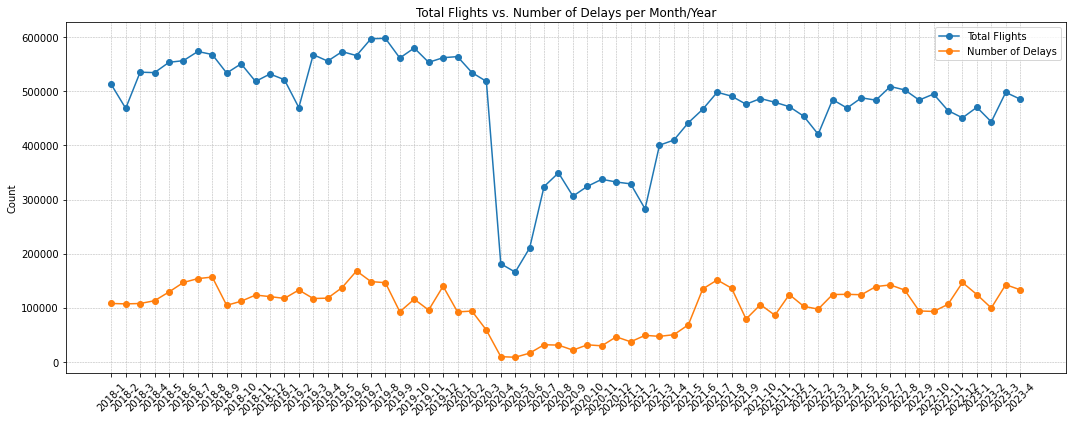

In [91]:
# import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd

# convert pyspark dataframe to pandas dataframe
df_pandas= df_overview.toPandas()
# create a date column with the 'year' and 'month column'
df_pandas['date']= df_pandas['Year'].astype(str)+ '-' +df_pandas['Month'].astype(str)
# set the new data column as index
df_pandas.set_index('date', inplace= True)

# initalize figure in size 15x6
plt.figure(figsize= (15,6))

# plot the number of total flights per month/year
plt.plot(df_pandas.index, df_pandas['num_total_flights'], label='Total Flights', marker='o')
# plot the number of delays per month/year
plt.plot(df_pandas.index, df_pandas['num_delayed_flights'], label='Number of Delays', marker='o')

# set x-axis label rotation by 45 defgrees for better readability
plt.xticks(rotation=45)
# set y-axis label
plt.ylabel('Count')
# define title for chart
plt.title('Total Flights vs. Number of Delays per Month/Year')
# displaying a legend for the chart
plt.legend()
# adjusting layout, that all labels titles fit in
plt.tight_layout()
# define the line style for the grid to increase readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# show chart
plt.show()

I have decided to use a graph at this point as it is very helpful to quickly identify visual trends. Of course, "the Corona year" jumps to the eye as there is a significant drop in the total number of flights and the subsequent "normalisation" of the airline industry. 

If you look at the graph a little longer, you can see an increase in the summer months and a decrease in especially in the month of January.

So a pattern in the seasonality of flights could be noticed. The line representing the delays is mirror the movement of the upper line. This shows the linearity of flights and delays again.

## Hypothesis III - Influence Due to Delays Caused by Bad Weather

In this section I would like to discuss delays caused by bad weather. It is important to note that the dataset only contains flights that are on time or delayed. Flights that did not take place are not included. This leads to the assumption that in the data represented here, the weather conditions before the start of a flight could not have been so bad that the flight had to be cancelled or that this led to dramatic delays. The following columns store information about delays:

In [145]:
delay_columns= [col for col in df_flights.columns if 'delay' in col.lower()]
for column in delay_columns:
    print(column)

DepDelay
DepDelayMinutes
ArrDelay
ArrDelayMinutes
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay


In the output above, all columns are displayed that have something to do with "delay". The columns with DepDelay, DepDelayMinutes, ArrDelay, ArrDelayMinutes have already been addressed. The focus will be specifically on the following columns:
- CarrierDelay
- WeatherDelay
- NASDelay
- SecurityDelay
- LateAircraftDelay

Based on the information, the main hypothesis is that bad weather conditions have the least impact on flight delays. The alternative hypothesis is: Delay is significantly influenced by bad weather conditions.
It should be noted that "bad weather conditions" manifest themselves in the form of a greater delay due to the corresponding delay caused by the weather.

This leads to the subordinate hypothesis that high delays can be derived from a combination of external factors. The alternative hypothesis is that high delays are due to an external factor.

For the technical implementation, I will adjust the structure of the data and use a linear regression model to check how the individual delay types influence the arrival delay. Using the model, I can query the P-values to check the statistical relevance of the delay types. I then perform a statistical descriptive analysis to determine the average values of each delay, as well as the median value. These values can be used to determine how strongly the individual factors, including external factors, influence a delay.


In [93]:
# Import required Libs
from pyspark.sql.functions import explode, array, struct,lit, col


# Store columnnames of delays for latter usage
delay_columns= ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']

# reorder data to have two columns storing the type of delay and delay itself
exprs= explode(array([
    struct(lit(c).alias('DelayType'), col(c).alias('DelayValue'))
    for c in delay_columns])).alias('exploded')

reshaped_data= df_flights.select(exprs).select('exploded.*')

In [62]:
# run linear regression with reshaped data
# import necessary libs
import time
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline

# Recording time to check time which is needed for execution
start_time= time.time()

# Indexing the categorical variable
indexer = StringIndexer(inputCol="DelayType", outputCol="DelayTypeIndex")

# One hot encoding
encoder = OneHotEncoder(inputCols=["DelayTypeIndex"], outputCols=["DelayTypeVec"])

# Assembling the features
assembler = VectorAssembler(inputCols=["DelayTypeVec"], outputCol="features")

# Linear regression
lr = LinearRegression(featuresCol="features", labelCol="DelayValue")

# Defining the Pipeline
pipline= Pipeline(stages=[indexer, encoder, assembler, lr])

# Fitting the model
pipline_model= pipline.fit(reshaped_data)

# Fetching th LR Model from the Pipline to get model summary
lr_model= pipline_model.stages[-1]
summary= lr_model.summary

end_time= time.time()

print(f'P-values for delay types: {summary.pValues}')

print(f'Time needed: {end_time - start_time} seconds.')

P-values for delay types: [0.0, 0.0, 0.0, 0.0, 0.0]
Time needed483.88009762763977


The fact that all p-values are presented as 0.0 means that all delays are statistically relevant predictors in the model. This means that each individual delay type contributes significantly to the total delay of a flight.

In [60]:
# Sample 20% of the data
sampled_df = df_flights.sample(False, 0.2)
pdf_sampled = sampled_df.select('CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay').toPandas()

f_val, p_val = stats.f_oneway(pdf_sampled['CarrierDelay'], pdf_sampled['WeatherDelay'], pdf_sampled['NASDelay'], pdf_sampled['SecurityDelay'], pdf_sampled['LateAircraftDelay'])

print(f"F-value: {f_val}")
print(f"P-value: {p_val}")

F-value: 75246.2961573213
P-value: 0.0


The extremely high F-value of 75'246.29 of the one-way ANOVA test shows that there are strong differences in the averages of the respective delay groups.  The p-value indicates that this difference is statistically relevant. This means that there is a significant difference in the average value for at least one type of delay.

Unfortunately, these analyses do not yet give me any explicit information to answer my hypothesis. On the current point, I can say that all types of delay have a significant influence on the total delay and that there is one group of delays that has a significantly different average value than the other groups. Therefore, I will first look at the average values of the respective groups and then conduct a two-sided T-test to determine the exact role of the weather.

In [66]:
# Descriptive Analysis
from pyspark.sql.functions import avg,expr

delay_types= ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']

for delay in delay_types:
    df_flights.select(avg(delay).alias(f'average {delay}'), expr(f'percentile({delay}, 0.5)').alias(f'median {delay}')).show()


+--------------------+-------------------+
|average CarrierDelay|median CarrierDelay|
+--------------------+-------------------+
|   5.050472623204474|                0.0|
+--------------------+-------------------+

+--------------------+-------------------+
|average WeatherDelay|median WeatherDelay|
+--------------------+-------------------+
|  0.8417200107577583|                0.0|
+--------------------+-------------------+

+------------------+---------------+
|  average NASDelay|median NASDelay|
+------------------+---------------+
|2.9941116738668248|            0.0|
+------------------+---------------+

+---------------------+--------------------+
|average SecurityDelay|median SecurityDelay|
+---------------------+--------------------+
| 0.027410878132546626|                 0.0|
+---------------------+--------------------+

+-------------------------+------------------------+
|average LateAircraftDelay|median LateAircraftDelay|
+-------------------------+-----------------------

In [148]:
# Stop spark session
spark_session.stop()

The above list shows the average delays of the respective delay type, as well as the corresponding median value. Each list shows a median value of 0.0, which allows conclusions to be drawn about the distribution of the data and means that in each delay category slightly more than every second value is 0, or the corresponding delay type is not present.

Furthermore, it can be seen that the CarrierDelay and LateAircraftDelay have the highest average values. On the other hand, the average value of WeatherDelay is relatively low. This partly supports the hypothesis that delays caused by the least have the smallest influence on the total delay. Only partially, because SecurityDelay has the lowest average value.

It can therefore be concluded that the hypothesis can neither be accepted nor rejected. Since the weather does not have the slightest influence on the delay of an aircraft. Nevertheless, the delay caused by bad weather is very small in this dataset. 

Regarding the sub-hypothesis, it can be said that the external factors CarreierDelay and LateAircraftDelay are the biggest drivers of a high arrival delay.

# Summary and Conclusion

## Instruction and Goals

The project was an exciting journey to understand the intricacies of flight delays. The main objectives were to identify patterns, dependencies and key drivers of delay. With a comprehensive data set covering different aspects of a flight and also meeting the requirements of a big data analysis, it made it possible to generate exciting hypotheses.  The main hypothesis revolved around delays and how they affect the arrival times of a flight.  The other hypothesis dealt with the linearity of delays and their drivers.

## Analysis Overview

I used pyspark's capabilities and the computational power of a distributed system to efficiently process and analyze a large amount of data. The arrival delay, as well as variables such as 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', and 'LateAircraftDelay' played a major role. A number of efforts have been made to analyze and understand the relationships and effects of this information.

The project took a mainly analytical approach, starting with exploratory data analysis, descriptive statistics and the use of analysis of variance (ANOVA). I also discovered the possibility of using linerar regression models to shed light on the relationships between variables.

## Challenges

From my point of view, the challenges were mainly technical implementation. Working with a large data set and on a distributed system forced me to rethink my approach because I often encountered storage errors. This made me realize that I had to approach it differently, even if I was working with "dataframes", which had nothing to do with the classic pandas dataframe. Some operations that were easily possible with the Pandas library, for example, were not so easy to implement in Pyspark and a rethink was required.

From a data perspective, it was suboptimal that parts of the data were already aggregated, such as the variable 'WeatherDelay'. It would have been very exciting, for example, to spot differences in the weather and how these affect delays.

## Results and Discussions

Depature vs. Arrival Delays: The first hypothesis could be refuted. Departure delays have a significant impact on arrival delays. Although some of the departure delays can be made up for, it is clear that a departure delay will very likely lead to a delay in arrival.
    
    
Linearity of Delays: I was also able to determine that flight delays behave in a linear manner. Simply put, this means that a large number of flights are experiencing increased delays. However, this does not mean that relatively speaking, there will be significantly more delays when there is a very high volume of flights than when there are fewer flights.
    
    
Wather Delays and External Factors: In this dataset, weather was not a primary driver of delays. The dataset only included delayed flights and no canceled flights, so weather, for example, was ignored as a criterion for canceling a flight. This means that the weather conditions must have been acceptable during the delay and therefore the weather only played a minor role. A delayed plane from the previous flight or delays caused by the airline have significantly increased the delay in arrival time.



## Summary

The project gave me a deep insight into the interwoven network of flight delays. It was able to successfully shed light on the field of delays and shed light on the connections. It also demonstrated PySpark's ability to process large amounts of data efficiently and quickly.

In summary, it can be said that the project clearly demonstrated the possibilities of 'big data' and the role that distributed networks play in this. I will be able to put the skills I have acquired into practical use and will also be able to broaden my horizons in analyzing data.

# References

[1] History of Flight, URL: “https://www.grc.nasa.gov/www/k-12/UEET/StudentSite/historyofflight.html#:~:text=The%20first%20manned%20flight%20was,de%20Rozier%20and%20Francois%20Laurent.&text=George%20Cayley%20worked%20to%20discover,of%20the%20body%20to%20control.”; visited 23/08/23

[2] Travel & Safery, International Air Transportation Association; URL: https://www.iata.org/en/youandiata/travelers/aviation-safety/; visited 23/08/23

[3] Number of Flights Worldwide in 2022/2023: Passenger Traffic, Behaviors, and Revenue, FinancesOnline – Reviews For Business; URL: https://financesonline.com/number-of-flights-worldwide/ ; Visited: 23/08/23

[4] Kaggle, Flight Delay -US Flight Delays: Arrival & Depature for Analysis and ML Modeling; URL: https://www.kaggle.com/datasets/arvindnagaonkar/flight-delay ; visited and downloaded: 23/08/23

[5] Apache Parquet, Motivation; URL: https://parquet.apache.org/docs/overview/motivation/ ; visited 24/08/23

[6] Bureau of Transportation Statistics, About the Bureau of Transportation Statistics; URL: https://www.bts.dot.gov/about-BTS ; Last update of site: 26/02/2019, visited: 24/08/2023

[7] Creative Commons, CC0 1.0 Universal (CC0 1.0) - Public Domain Dedication; URL: https://creativecommons.org/publicdomain/zero/1.0/; visited 24/08/23

[8] Kaggle – Flight Delay: About Dataset; URL: https://www.kaggle.com/datasets/arvindnagaonkar/flight-delay, visited: 24/08/23